In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
# 1. toll arxiv
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
# 2. tool wikipedia 
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')


In [6]:
### tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily= TavilySearchResults()

In [7]:
tavily.invoke("provide me the recent AI news?")

[{'title': 'Artificial Intelligence News - ScienceDaily',
  'url': 'https://www.sciencedaily.com/news/computers_math/artificial_intelligence/',
  'content': 'Artificial Intelligence News\n\nTop Headlines\n\nLatest Headlines\n\nEarlier Headlines\n\nThursday, May 8, 2025\n\nWednesday, May 7, 2025\n\nTuesday, May 6, 2025\n\nMonday, May 5, 2025\n\nThursday, May 1, 2025\n\nFriday, April 25, 2025\n\nThursday, April 24, 2025\n\nWednesday, April 23, 2025\n\nTuesday, April 22, 2025\n\nTuesday, April 15, 2025\n\nMonday, April 14, 2025\n\nWednesday, April 9, 2025\n\nTuesday, April 8, 2025\n\nThursday, April 3, 2025\n\nThursday, March 27, 2025\n\nWednesday, March 26, 2025\n\nTuesday, March 25, 2025 [...] Thursday, January 16, 2025\n\nWednesday, January 15, 2025\n\nTuesday, January 14, 2025\n\nThursday, January 9, 2025\n\nWednesday, January 8, 2025\n\nMonday, January 6, 2025\n\nThursday, January 2, 2025\n\nFriday, December 27, 2024\n\nThursday, December 26, 2024\n\nThursday, December 19, 2024\n\nWe

In [8]:
## combine all these tools in the list
tools=[arxiv, wiki, tavily]

In [10]:
# Initialize the LLM Model
from langchain_groq import ChatGroq
llm=ChatGroq(model='qwen-qwq-32b')

In [11]:
llm.invoke("What is AI")

AIMessage(content='\n<think>\nOkay, the user is asking, "What is AI?" Let me start by breaking down the term. AI stands for Artificial Intelligence. I should explain that it\'s a field of computer science. But maybe I should also mention the broader definition. Some people think of AI as any machine that can perform tasks requiring human-like intelligence.\n\nHmm, should I differentiate between general AI and narrow AI? Probably important to note that most AI today is narrow, like voice assistants or recommendation systems. General AI, which is more human-like, is still theoretical.\n\nI need to cover the key areas of AI. Machine learning comes to mind, especially since it\'s a subset of AI. Deep learning is a part of machine learning using neural networks. I should give examples of each to make it clearer.\n\nApplications are essential too. Things like healthcare, finance, transportation. Maybe mention some popular examples like self-driving cars or chatbots. Also, touch on current li

In [12]:
llm_with_tools=llm.bind_tools(tools=tools)

In [13]:
llm_with_tools.invoke("What is recent news on AI")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8d74', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 219, 'prompt_tokens': 354, 'total_tokens': 573, 'completion_time': 0.505888843, 'prompt_time': 0.030768348, 'queue_time': 0.266030812, 'total_time': 0.536657191}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--94327692-8781-4753-82c3-69dcc24f7e31-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news on AI'}, 'id': 'call_8d74', 'type': 'tool_call'}], usage_metadata={'input_tokens': 354, 'output_tokens': 219, 'total_tokens': 573})

 WORKFLOW

In [14]:
## state schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage   ## human message or AI message
from typing import Annotated     ## labeling
from langgraph.graph.message import add_messages   ## reducers in langgraph

In [15]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]


In [16]:
#3 now we will be creating two nodes the Ai Assistand node and tools node and the we will creating edges to connect start with AI assistant node

In [17]:
# Entire chatbot with langGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

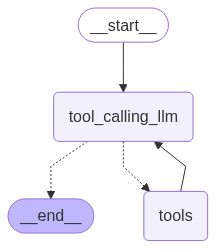

In [23]:
## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build Graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if latest message from assistant is a tool call ->  tools_condition routes to tools
    # if latest message from assistant is anot a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tools", END)

graph=builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
messages=graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_7a80)
 Call ID: call_7a80
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
================================== Ai Message ==================================

The paper **"Attention Is All You Need"** (arXiv ID: 1706.03762), p

In [25]:
messages=graph.invoke({"messages":"Hi My name is Ashu"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi My name is Ashu
================================== Ai Message ==================================

Hello Ashu! Nice to meet you. How can I assist you today?


In [26]:
messages=graph.invoke({"messages":"Hi My name is Ashu and please tell me the recent research paper on blockchain  "})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi My name is Ashu and please tell me the recent research paper on blockchain  
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_fcw4)
 Call ID: call_fcw4
  Args:
    query: blockchain
================================= Tool Message =================================
Name: arxiv

Published: 2023-04-19
Title: Vulnerability of Finitely-long Blockchains in Securing Data
Authors: Yiming Jiang, Jiangfan Zhang
Summary: Recently, blockchain has been applied in various fields to secure data
exchanges and storage in decentralized systems. In a blockchain application
where the task of the application which makes use of the data stored in a
blockchain has to be accomplished by a time instant, the employed blockchain is
essentially finitely-long. In this paper, we consider a general
================================== Ai Message ==================================

In [28]:
messages=graph.invoke({"messages":"What is the recent AI news and then please tell me the recent research paper on blockchain  "})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news and then please tell me the recent research paper on blockchain  
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_k16x)
 Call ID: call_k16x
  Args:
    query: recent AI news
  arxiv (call_z65j)
 Call ID: call_z65j
  Args:
    query: blockchain recent research
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Latest AI Breakthroughs and News: April- May 2025 - Crescendo.ai", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "Date: April 30, 2025Summary: Conservative activist Robby Starbuck has filed a $5 million defamation lawsuit against Meta, alleging that its AI chatbot falsely claimed he participated in the January 6 Capitol riot and was affiliated with QAnon. Despite contacting Meta to correct

In [29]:
messages=graph.invoke({"messages":"What is the recent Agentic AI news and then please tell me about machine learning  "})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent Agentic AI news and then please tell me about machine learning  
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_4j24)
 Call ID: call_4j24
  Args:
    query: Recent Agentic AI news 2024
  wikipedia (call_ywyw)
 Call ID: call_ywyw
  Args:
    query: machine learning
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Feature: Operators call up agentic AI - Mobile World Live", "url": "https://www.mobileworldlive.com/att/feature-operators-call-up-agentic-ai/", "content": "Feature: Operators call up agentic AI\n\nAgentic AI has swept across the telecom and business sectors this year after largely being a curiosity in 2024, a remarkable rate of acceleration which highlights its pivotal role.\n\nAndy Markus, SVP, chief data and AI officer a